Random Forest using Kaggle Animal Shelter Dataset
https://www.kaggle.com/c/shelter-animal-outcomes

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob

%matplotlib inline

In [2]:
mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'

linux_data_dir = '/home/chris/data'

win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [3]:
data_dir = linux_data_dir

In [4]:
# Data cleanup
# TRAIN DATA
train_df = pd.read_csv(os.path.join(data_dir, 'shelter_train.csv'), header=0)        # Load the train file into a dataframe

In [5]:
train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [7]:
outcomes_all = train_df.OutcomeType.unique()
outcomes_all

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

In [8]:
train_dogs = train_df.where(train_df['AnimalType']=='Dog')

In [9]:
train_dogs.dropna(inplace=True)

In [10]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,Dog,Neutered Male,4 years,Pit Bull Mix,Brown
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,Dog,Intact Male,2 months,Queensland Heeler Mix,Black/White
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,Dog,Intact Male,4 months,Labrador Retriever Mix,Black/White


In [11]:
outcomes = train_dogs.OutcomeType.unique()
outcomes

array(['Adoption', 'Transfer', 'Euthanasia', 'Died'], dtype=object)

Dogs aren't returned to their owners? WTF?

In [18]:
counts = train_dogs.groupby('OutcomeType').count()
counts

,AnimalID,Name,DateTime,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
OutcomeType,,,,,,,,,
Adoption,675,675,675,675,675,675,675,675,675
Died,18,18,18,18,18,18,18,18,18
Euthanasia,584,584,584,584,584,584,584,584,584
Transfer,2673,2673,2673,2673,2673,2673,2673,2673,2673


In [24]:
dates_cross = pd.crosstab(train_dogs.DateTime, train_dogs.OutcomeType)

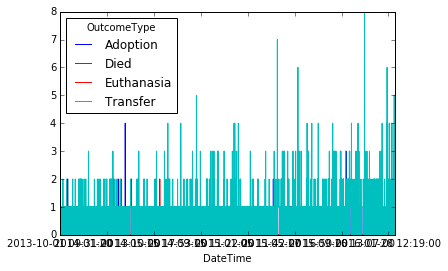

In [25]:
dates_cross.plot()

In [ ]:
from sklearn import preprocessing

In [ ]:
encoder = preprocessing.LabelEncoder()

In [ ]:
encoder.fit(outcomes)

In [ ]:
encoded_y = encoder.transform(outcomes)

In [ ]:
encoded_y

In [ ]:
list(encoder.inverse_transform([1, 2, 3]))

In [ ]:
# convert integers into dummy variables (one hot encoding)
from keras.utils import np_utils

dummy_y = np_utils.to_categorical(encoded_y)

In [ ]:
dummy_y

In [ ]:
# Transform value in DF

train_dogs.OutcomeType = encoder.transform(train_dogs.OutcomeType)

In [ ]:
train_dogs.describe()

### Cleaning the Data

In [ ]:
train_dogs.OutcomeSubtype.unique()

In [ ]:
# Should convert all of these using LabelEncoder

outcome_sub = {}
for i, st in enumerate(train_dogs.OutcomeSubtype.unique()):
    outcome_sub[st] = i

In [ ]:
train_dogs['OutcomeSubtype'] = train_dogs.OutcomeSubtype.map( outcome_sub ).astype(int)

In [ ]:
train_dogs.AnimalType.unique()

In [ ]:
train_dogs.drop('AnimalType', 1)

In [ ]:
train_dogs.SexuponOutcome.unique()

In [ ]:
sex_outcome = {}
for i, sex in enumerate(train_df.SexuponOutcome.unique()):
    sex_outcome[sex] = i

In [ ]:
sex_outcome

In [ ]:
train_dogs['SexuponOutcome'] = train_df.SexuponOutcome.map( sex_outcome ).astype(int)

In [ ]:
train_dogs.AgeuponOutcome.unique()

In [ ]:
period_dict = {'year': 365, 'month': 30, 'week': 7, 'day': 1, 'day': 1}

def convert_age_to_months(age):
    try:
        number, period = str(age).split()
        period = period.rstrip("s")
        days = int(number) * period_dict[period]
        return round(int(days) / 30, 0)
    except ValueError:
        return 1
    

In [ ]:
train_dogs['AgeuponOutcome'] = train_df.AgeuponOutcome.apply(convert_age_to_months)

In [ ]:
train_dogs.AgeuponOutcome[:10]

In [ ]:
train_dogs.Breed.unique()

In [ ]:
len(train_dogs.Breed.unique())

In [ ]:
# Could do something with a countvectorizer for Breed & Color, but we'll stick to simple here

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()

In [ ]:
def split_into_tokens(message):
    return TextBlob(message.lower()).words

In [ ]:
def split_into_lemmas(message):
    words = TextBlob(message.lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

train_dogs.Breed.head().apply(split_into_lemmas)

In [ ]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_dogs.Breed)
len(bow_transformer.vocabulary_)


In [ ]:
bow_transformer.get_feature_names()[3]

In [ ]:
breed_bow = bow_transformer.transform(train_dogs.Breed)
print( 'sparse matrix shape:', breed_bow.shape)
print( 'number of non-zeros:', breed_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * breed_bow.nnz / (breed_bow.shape[0] * breed_bow.shape[1])))

In [ ]:
print(breed_bow[1])

In [ ]:
train_dogs['Breedbow'] = bow_transformer.fit_transform(train_dogs.Breed)

In [ ]:
train_dogs.head()

In [ ]:
tfidf_transformer = TfidfTransformer().fit(breed_bow)

In [ ]:
breed_tfidf = tfidf_transformer.transform(breed_bow)

In [ ]:
n_clusters = 5

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, verbose=0)

In [ ]:
km_breeds = km.fit_predict(breed_tfidf)

In [ ]:
km.predict(breed_tfidf[4])

In [ ]:
# Visualizing the K-Means clusters
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(breed_tfidf)

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=km.labels_, marker="x")

In [ ]:
train_dogs['BreedKMeans'] = km_breeds

In [ ]:
train_dogs.head()

In [ ]:
# We should really do the same thing with color
len(train_dogs.Color.unique())

In [ ]:
color = {}

for i, c in enumerate(train_df.Color.unique()):
    color[c] = i
    
train_df['Color'] = train_df.Color.map( color ).astype(int)

In [ ]:
# We could also do something very cool with text analysis for names, but we'll keep it simple and go length

train_dogs['Name'] = train_df.Name.apply(lambda x: len(str(x)))

In [ ]:
train_dogs.interpolate().head() # could have used dropna().median()

In [ ]:
# Save our clean dataframe to csv so we don't need to do this again.
train_dogs.to_csv(os.path.join(data_dir, "clean_train.csv"))

In [ ]:
train_dogs.columns

In [ ]:
train_dogs.head()

In [ ]:
# Work out a test_train_split to see how we do
X = train_dogs.drop(['AnimalID', 'AnimalType', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'Breed', 'Breedbow'], axis=1)
X.dtypes

In [ ]:
X.AgeuponOutcome.replace('NA',0)

In [ ]:
X.columns

In [ ]:
train_features = X.values
train_features[:10]

In [ ]:
dummy_y

In [ ]:
train_target = np_utils.to_categorical(train_dogs['OutcomeType'].values)
train_target

In [ ]:
simple_target = train_dogs.OutcomeType.values
simple_target

In [ ]:
# Set up our train_test_split

X_train, x_test, y_train, y_test = train_test_split(train_features,
                                          train_target,
                                          test_size=0.2,
                                          random_state=42)

In [ ]:

simple_X_train, simple_x_test, simple_y_train, simple_y_test = train_test_split(train_features,
                                          simple_target,
                                          test_size=0.2,
                                          random_state=42)

In [ ]:
# New we finally get to the classifier!

clf = RandomForestClassifier(n_estimators=100)

In [ ]:
# Categorical classifier
clf = clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
"Mean accuracy of Random Forest: {0}".format(score)

In [ ]:
# Simple classifier
S_clf = clf.fit(simple_X_train, simple_y_train)
score = clf.score(simple_X_train, simple_y_train)
"Mean accuracy of Random Forest: {0}".format(score)

In [ ]:
clf.predict(x_test[0])

In [ ]:
S_clf.predict(simple_x_test[0])

In [ ]:
outcomes

In [ ]:
def reverse_dict_search(d, target):
    for k, v in d.items():
        if v == target:
            return k

In [ ]:
def predict_outcome(animal):
    
    predict = np.argmax(clf.predict(animal))
    predict_prob = list(clf.predict_proba(animal))
    
    outcome_n = [0, 1, 2, 3, 4]
        
    name, sex, age, animal_color, animal_breed = animal
    print("Name length:{}".format(name))
    print("Sex:{}".format(reverse_dict_search(sex_outcome, sex)))
    print("Age:{} months".format(age))
    print("Breed Cluster:{}".format(animal_breed))
    print("Color:{}\n".format(reverse_dict_search(color, animal_color)))
    print("************")
    print("Prediction: {} ({})\n".format(encoder.inverse_transform(
                predict), round(predict_prob[predict][0][1],2)))
    print("************")
    print("Breakdown")
    for i in range(0,5):
        print("{}: {}".format(encoder.inverse_transform(i), round(predict_prob[i][0][1],2)))
   

In [ ]:
clf.predict_proba(x_test[5])

In [ ]:
encoder.inverse_transform(clf.predict(x_test[5]))

In [ ]:
predict_outcome(x_test[5])

In [ ]:
# Evaluate the model
print (X_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

In [ ]:
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(x_test)

print ("Accuracy = %.2f" % (accuracy_score(y_test, y_predict)))

In [ ]:
# Create classification report for test data

categories = ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']

print(classification_report(y_test, 
                            y_predict, 
                            target_names=categories))

In [ ]:
# Metrics for the simple labels classifier

S_y_predict = S_clf.predict(simple_x_test)

print ("Accuracy = %.2f" % (accuracy_score(simple_y_test, S_y_predict)))

model_score = S_clf.score(simple_x_test, simple_y_test)
print ("Model Score %.2f \n" % (model_score))

confusion_matrix = metrics.confusion_matrix(simple_y_test, S_y_predict)
print ("Confusion Matrix \n", confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    # Simple plot based on the Iris sample CM
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(confusion_matrix, categories, title="Animal Sanctuary Confusion Matrix")

In [ ]:
print(average_precision_score(y_test, y_predict))

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp

In [ ]:
print(roc_auc_score(y_test, y_predict))

In [ ]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot the importance of the different features

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
for i in [4, 3, 2, 5, 1, 0]:
    print("Feature {}: {}".format(i, X.columns[i]))

In [ ]:
# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values

In [ ]:
print 'Training...'
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit( train_data[0::,1::], train_data[0::,0] )

In [ ]:
print 'Predicting...'
output = forest.predict(test_data).astype(int)

In [ ]:
predictions_file = open("myfirstforest.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'